### 1. Setup

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from scipy.spatial.distance import cdist
from scipy import stats
import matplotlib.pyplot as plt

In [41]:
# generate a target process
def generate_sequence(length):
    sequence = []
    while len(sequence) < length:
        sequence.extend([1, 0])
        next_symbol = random.choice([1, 0])
        sequence.append(next_symbol)
    return sequence[:length]

sequence_length = 204
sequence = generate_sequence(sequence_length)

window_length = 12
num_windows = sequence_length // window_length
if sequence_length % window_length != 0:
    num_windows += 1

# model definition
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.w_h = nn.Linear(3, 4)
        self.w_s = nn.Linear(4, 3)
        self.w_o = nn.Linear(4, 1)
        self.activation = nn.Sigmoid()
        self.activation_hidden = nn.ReLU()

    def forward(self, s_t):
        h_t = self.activation_hidden(self.w_h(s_t))
        s_t_next = self.activation_hidden(self.w_s(h_t))
        o_t = self.activation(self.w_o(h_t))
        return s_t_next, o_t

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, a=-1.0, b=1.0)
        if m.bias is not None:
            nn.init.uniform_(m.bias, a=-1.0, b=1.0)

model = RNNModel()
model.apply(init_weights)
criterion = nn.BCELoss()

# define the initial state for each window as a learnable parameter
s0_list = [torch.nn.Parameter(torch.zeros(3)) for _ in range(num_windows)]
for s0 in s0_list:
    s0.requires_grad = True

optimizer = optim.SGD(
    list(model.parameters()) + s0_list, lr=0.0001, momentum=0.9
)

num_epochs = 2500

# decay coefficient
nu = 0.8

mse_history = []
output_history = []
lyapunov_exponents = []

# Lyapunov exponent
def calculate_lyapunov(outputs, emb_dim=5, tau=1, k_max=50, theiler_window=5):
    """
    outputs: time series data array
    emb_dim: embedding dimension
    tau: time delay
    k_max: maximum time step
    theiler_window: window size to avoid autocorrelation
    """
    N = len(outputs)
    # embedding vector creation
    M = N - (emb_dim - 1) * tau
    if M <= 0:
        raise ValueError("The data is too short to embed.")

    Y = np.zeros((M, emb_dim))
    for i in range(M):
        Y[i] = outputs[i : i + emb_dim * tau : tau]

    # search for nearest neighbors
    distances = cdist(Y, Y)
    np.fill_diagonal(distances, np.inf)
    for i in range(M):
        distances[i, max(0, i - theiler_window):min(M, i + theiler_window + 1)] = np.inf

    nearest_neighbor_idx = np.argmin(distances, axis=1)

    # calculate the distance
    divergence = np.zeros((M, k_max))
    for i in range(M):
        j = nearest_neighbor_idx[i]
        for k in range(k_max):
            if i + k < M and j + k < M:
                diff = Y[i + k] - Y[j + k]
                divergence[i, k] = np.linalg.norm(diff)
            else:
                divergence[i, k] = np.nan

    # calculate the average divergence
    avg_divergence = np.nanmean(divergence, axis=0)
    ln_divergence = np.log(avg_divergence)

    # estimate the Lyapunov exponent
    k_range = np.arange(k_max)
    slope, intercept, r_value, p_value, std_err = stats.linregress(k_range, ln_divergence)
    return slope


### 2. Learning

In [42]:
for epoch in range(num_epochs):
    total_loss = 0.0
    epoch_outputs = []
    for window_idx in range(num_windows):
        # get the current window sequence
        start_idx = window_idx * window_length
        end_idx = min(start_idx + window_length, len(sequence))
        window_sequence = sequence[start_idx:end_idx]

        # get the learnable initial state
        s_t = s0_list[window_idx]

        window_loss = 0.0

        # list to track gradients
        s_t_list = [s_t]

        for time_step in range(len(window_sequence)):
            target = torch.tensor([window_sequence[time_step]], dtype=torch.float32)

            # retain the gradient of s_t
            s_t.retain_grad()

            s_t_next, o_t = model(s_t)
            epoch_outputs.append(o_t.item())

            loss = criterion(o_t, target)
            window_loss += loss

            s_t = s_t_next
            s_t_list.append(s_t)

        optimizer.zero_grad()
        window_loss.backward(retain_graph=True)

        # apply the decay coefficient to the state gradients
        with torch.no_grad():
            for i in range(1, len(s_t_list)):
                if s_t_list[i].grad is not None:
                    s_t_list[i].grad *= nu ** i

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()
        total_loss += window_loss.item()

    mean_loss = total_loss / num_windows
    mse_history.append(mean_loss)

    lyapunov = calculate_lyapunov(epoch_outputs)
    lyapunov_exponents.append(lyapunov)

    output_history.append(epoch_outputs)

    if (epoch + 1) % 100 == 0:
        mean_loss = total_loss / num_windows
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {mean_loss:.4f}')

/var/folders/cj/n98ksxx11yz7hvj1cmrwm_780000gn/T/ipykernel_11676/727138510.py:39: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  if s_t_list[i].grad is not None:


Epoch 100/2500, Loss: 2.7222
Epoch 200/2500, Loss: 2.0975
Epoch 300/2500, Loss: 1.8806
Epoch 400/2500, Loss: 2.7418
Epoch 500/2500, Loss: 2.4155
Epoch 600/2500, Loss: 2.3883
Epoch 700/2500, Loss: 2.2775
Epoch 800/2500, Loss: 2.7807
Epoch 900/2500, Loss: 2.6912
Epoch 1000/2500, Loss: 2.6745
Epoch 1100/2500, Loss: 2.6677
Epoch 1200/2500, Loss: 2.6544
Epoch 1300/2500, Loss: 2.6559
Epoch 1400/2500, Loss: 2.6846
Epoch 1500/2500, Loss: 2.5647
Epoch 1600/2500, Loss: 2.4354
Epoch 1700/2500, Loss: 2.3063
Epoch 1800/2500, Loss: 2.3067
Epoch 1900/2500, Loss: 2.2460
Epoch 2000/2500, Loss: 2.1866
Epoch 2100/2500, Loss: 2.1414
Epoch 2200/2500, Loss: 2.1285
Epoch 2300/2500, Loss: 2.1153
Epoch 2400/2500, Loss: 2.0930
Epoch 2500/2500, Loss: 1.8157


### 3. Evaluation

Evaluation Loss: 0.3162
Accuracy: 81.37%


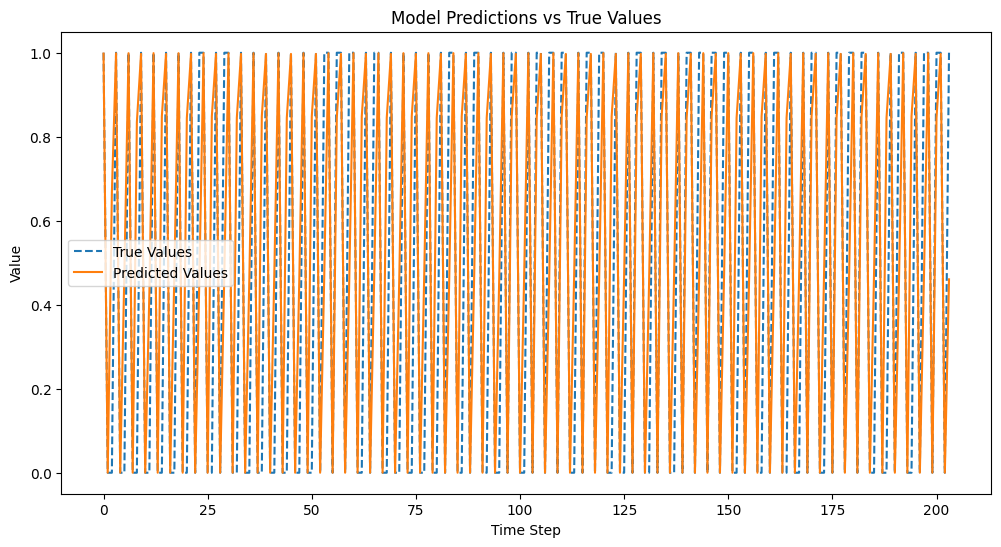

In [43]:

test_sequence_length = 204
test_sequence = generate_sequence(test_sequence_length)

model.eval()

window_length = 12
num_windows = test_sequence_length // window_length
if test_sequence_length % window_length != 0:
    num_windows += 1

all_targets = []
all_predictions = []

s_t = torch.zeros(3)

with torch.no_grad():
    total_loss = 0.0
    criterion = nn.BCELoss()

    for window_idx in range(num_windows):
        start_idx = window_idx * window_length
        end_idx = min(start_idx + window_length, len(test_sequence))
        window_sequence = test_sequence[start_idx:end_idx]

        window_loss = 0.0

        for time_step in range(len(window_sequence)):
            target = torch.tensor([test_sequence[start_idx + time_step]], dtype=torch.float32)

            s_t_next, o_t = model(s_t)

            prediction = o_t.item()
            all_predictions.append(prediction)
            all_targets.append(target.item())

            loss = criterion(o_t, target)
            window_loss += loss.item()

            s_t = s_t_next

        total_loss += window_loss

    average_loss = total_loss / test_sequence_length
    print(f'Evaluation Loss: {average_loss:.4f}')

# Threshold processing of prediction results (threshold is 0.5)
threshold = 0.5
binary_predictions = [1 if pred >= threshold else 0 for pred in all_predictions]

correct_predictions = sum([1 for pred, target in zip(binary_predictions, all_targets) if pred == target])
accuracy = correct_predictions / len(all_targets) * 100
print(f'Accuracy: {accuracy:.2f}%')

plt.figure(figsize=(12, 6))
plt.plot(all_targets, label='True Values', linestyle='--')
plt.plot(all_predictions, label='Predicted Values')
plt.legend()
plt.title('Model Predictions vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()

### 4-1. Mean square error

Text(0, 0.5, 'mean square error')

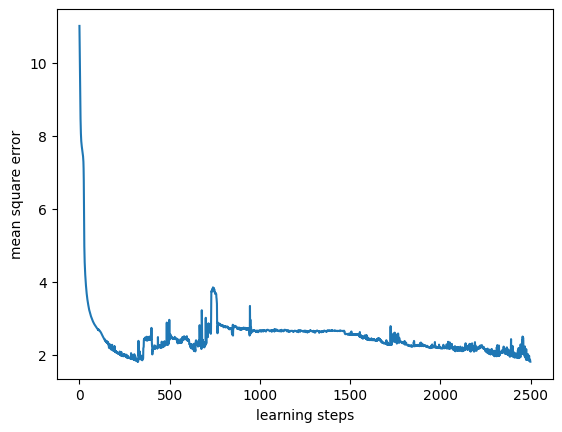

In [44]:
plt.plot(mse_history)
plt.xlabel('learning steps')
plt.ylabel('mean square error')

### 4-2. Lyapunov exponent
During the early stages of training, the maximum Lyapunov exponent was negative, but as the training progressed, it changed to positive.   

This indicates that the internal dynamics are evolving towards chaos.

Text(0, 0.5, 'Lyapunov exponent')

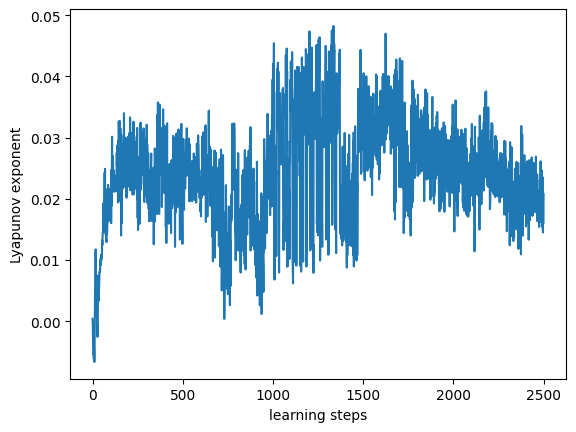

In [45]:
plt.plot(lyapunov_exponents)
plt.xlabel('learning steps')
plt.ylabel('Lyapunov exponent')

### 4-3. Internal dynamics
The steady-state dynamics persist at a fixed point around 0.5 for several tens of steps. 

Then, a sudden period-three bifurcation occurs, and a period-3 limit cycle begins. At this point, the emerging strategy generates sequences such as "1.0, 0.0, 0.5" instead of continuously producing a sequence of "0.5," resulting in a dramatic reduction in error. This limit cycle structure continues until around 300 steps, after which it starts to bifurcate, leading to a limit cycle with an even longer period. 

When expressed in symbolic dynamics, where outputs below 0.5 are represented as "0" and outputs above 0.5 as "1," this sequence can be described as "(101)(100)- - -". Chaos emerges after 300 steps, at which point the Lyapunov exponent becomes positive.

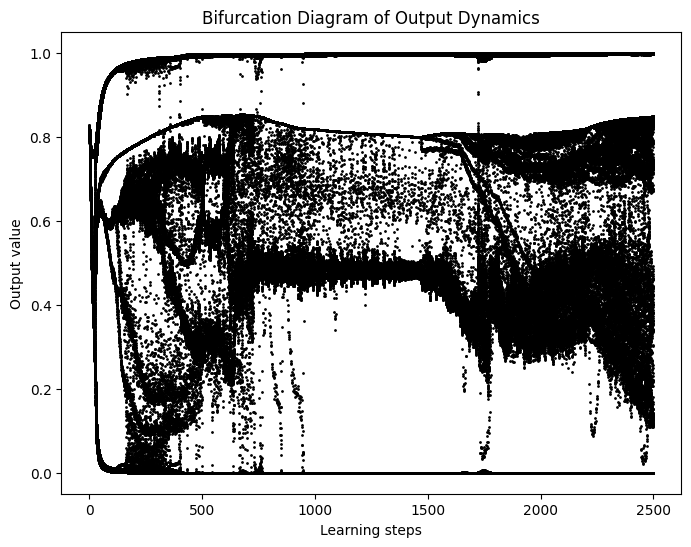

In [46]:
import numpy as np
import matplotlib.pyplot as plt

steady_state_start = 1

def extract_steady_state_outputs(output_history, start_step):
    steady_state_outputs = []
    for epoch_outputs in output_history[start_step:]:
        steady_state_outputs.append(epoch_outputs)
    return steady_state_outputs

def plot_bifurcation_diagram(output_history, start_step=steady_state_start):
    steady_state_outputs = extract_steady_state_outputs(output_history, start_step)
    
    plt.figure(figsize=(8, 6))
    
    for step, outputs in enumerate(steady_state_outputs):
        # visualize how the output values are changing with a scatter plot
        step_idx = step + start_step
        plt.scatter([step_idx] * len(outputs), outputs, color='black', s=1)
    
    plt.title("Bifurcation Diagram of Output Dynamics")
    plt.xlabel("Learning steps")
    plt.ylabel("Output value")
    plt.show()

plot_bifurcation_diagram(output_history)


### 4-4. 3D trajectory of states
> The transitions from current time to next time are indicated by connected lines, shown as a
2-D pro jection of the original 3-D internal state space. It app ears that the tra jectory go es
around three regions p erio dically. This is not, however, limit cycling since each region has a
certain width. (If it were limit cycling having a p erio d of three, the tra jectory would simply b e
a triangle connecting three p oints.)

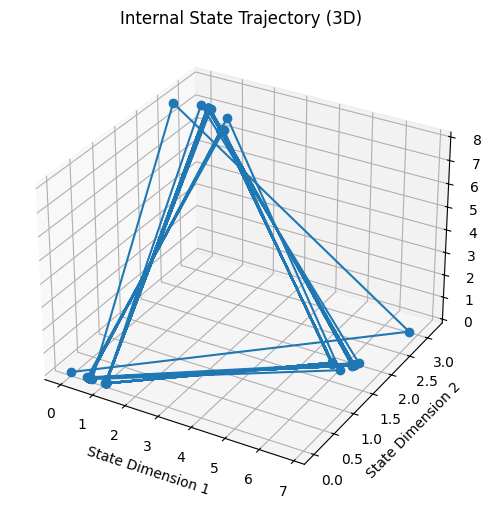

In [47]:
model.eval()

# 新しいシーケンスを生成
test_sequence_length = 100  # プロット用のシーケンス長
test_sequence = generate_sequence(test_sequence_length)

# 初期状態をゼロベクトルで設定
s_t = torch.zeros(3)

# 内部状態を保存するリスト
eval_states = []

with torch.no_grad():
    for time_step in range(len(test_sequence)):
        s_t_next, o_t = model(s_t)
        eval_states.append(s_t.numpy())
        s_t = s_t_next

eval_states = np.array(eval_states)

# 3次元プロット
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(eval_states[:, 0], eval_states[:, 1], eval_states[:, 2], marker='o')
ax.set_title('Internal State Trajectory (3D)')
ax.set_xlabel('State Dimension 1')
ax.set_ylabel('State Dimension 2')
ax.set_zlabel('State Dimension 3')
plt.show()

### 4-5. 2D projection of states by PCA

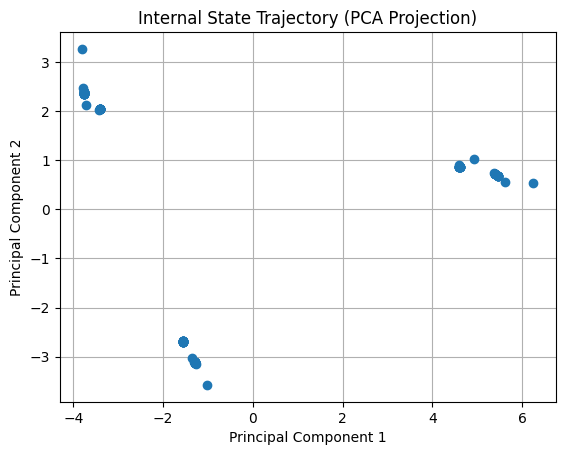

In [48]:
from sklearn.decomposition import PCA

# 内部状態をNumPy配列に変換
eval_states = np.array(eval_states)

# PCAによる2次元への次元削減
pca = PCA(n_components=2)
states_pca = pca.fit_transform(eval_states)

# プロット
plt.plot(states_pca[:, 0], states_pca[:, 1], 'o')
plt.title('Internal State Trajectory (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()